# Benchmarking scripts for novoSpaRc

## Intallation of the running environment

* Install the envrioment of novoSpaRC based on the instructions: https://github.com/rajewsky-lab/novosparc

In [4]:
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse
import logging
from scipy.spatial.distance import cdist
import seaborn as sns
logging.getLogger().setLevel(logging.INFO)
import utils

import random
random.seed(0)

## Utilized functions

In [5]:
def reconstruct(ref_adata,query_adata):
    
    if(issparse(ref_adata.X)):
        ref_adata.X = np.asarray(ref_adata.X.todense())
        
    if(issparse(query_adata.X)):
        print("test data sparse to dense")
        query_adata.X = np.asarray(query_adata.X.todense())
    
    dataset = query_adata
    gene_names = query_adata.var_names
    num_cells, num_genes = dataset.shape
    
    sc.pp.highly_variable_genes(ref_adata)
    is_var_gene = ref_adata.var['highly_variable']
    var_genes  = list(is_var_gene.index[is_var_gene])
    dge_rep = ref_adata.to_df()[var_genes]
    atlas_genes = var_genes
    
    num_locations = num_cells
    locations =  np.column_stack((ref_adata.obs['x'].values,ref_adata.obs['y'].values))
    
    train_index = list(range(locations.shape[0]))
    random.shuffle(train_index)
    random_selected_index = train_index[:num_locations]
    locations_apriori  = locations[random_selected_index]
    locations = locations_apriori
    
    atlas = ref_adata[random_selected_index,:]
    num_neighbors_s = num_neighbors_t = 5
    tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations, output_folder="./")
    
    markers = list(set(atlas_genes).intersection(gene_names))
    atlas_matrix = atlas.to_df()[markers].values
    markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
    markers_to_use = np.concatenate(markers_idx.loc[markers].values)
    
    tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)
    
    alpha_linear = 0.8
    epsilon = 5e-3
    tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)
    
    sdge = tissue.sdge
    dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
    dataset_reconst.obsm['spatial'] = locations
    gw = tissue.gw
    return gw,locations

    
    pass

In [6]:
def getLocations(predefined_locations, predict_probs):
    
    predicted_coors = []
    
    for i,cur_probs in enumerate(predict_probs):
        
        cur_max_coor_idx = np.argmax(cur_probs)
        cur_predict_coor = predefined_locations[cur_max_coor_idx]
        predicted_coors.append(cur_predict_coor)
        
    
    return np.asarray(predicted_coors)
    
    

## 1. Spatial reconstruction of mouse gastrulation cells using single-cell resolution ST reference

### 1.1 Load data


In [4]:
DATA_ROOT = "../benchmarking_data"

embryo1_l1 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))

print(embryo1_l1.shape,embryo1_l2.shape,embryo2_l2.shape,embryo3_l2.shape)

(10150, 351) (7656, 351) (6524, 351) (9408, 351)


### 1.2 Reconstruct and evaluation


In [20]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}
# set reference data
ref_adata = embryo1_l1

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
    logging.info("Aligning data for "+test_name)
    query_adata = cur_test_adata
    predict_probs,predefined_locations = reconstruct(ref_adata,query_adata)
    predicted_coor = getLocations(predefined_locations, predict_probs)
    logging.info("Aligning DONE")
    
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for embryo1_l2


cell_expression.shape (7656, 95) atlas_expression.shape (7656, 95) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 38.19 seconds )
Reconstructing spatial information with 95 markers: 7656 cells and 7656 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:18<00:00, 411.84it/s]
INFO:root:Aligning data for embryo2_l2


cell_expression.shape (6524, 95) atlas_expression.shape (6524, 95) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 27.41 seconds )
Reconstructing spatial information with 95 markers: 6524 cells and 6524 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6524/6524 [00:14<00:00, 449.58it/s]
INFO:root:Aligning data for embryo3_l2


cell_expression.shape (9408, 95) atlas_expression.shape (9408, 95) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 60.62 seconds )
Reconstructing spatial information with 95 markers: 9408 cells and 9408 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9408/9408 [00:26<00:00, 352.68it/s]


In [21]:
res_summary_all.to_csv("results/novosparc_mouse_single_cell_ref.csv")

### 1.3 Benchmarking results

#### 1.3.1 Neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

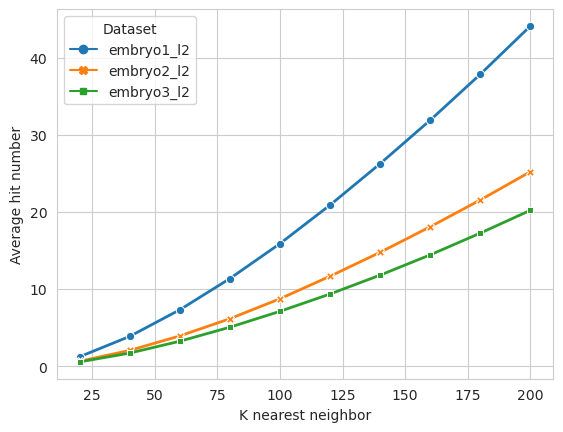

In [22]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 1.3.2 Average JSD and  spearman's rank correlation coefficient

In [23]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.417052,0.470905
1,embryo2_l2,0.434477,0.162065
2,embryo3_l2,0.521769,0.198829


## 2. Spatial location inference across platforms: mouse gastrulation datasets


## 2.1 Load data

In [25]:
# Please modify the data path as needed
DATA_ROOT = "../benchmarking_data"
stereoseq_E2S1 = sc.read_h5ad(os.path.join(DATA_ROOT,"stereoseq_E2S1.h5ad"))
embryo1_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo1_l2.h5ad"))
embryo2_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo2_l2.h5ad"))
embryo3_l2 = sc.read_h5ad(os.path.join(DATA_ROOT,"seqFISH_embryo3_l2.h5ad"))
train_adata = stereoseq_E2S1

### 2.2 Spatial reconstruction and evaluation


In [26]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}
# set reference data
ref_adata = stereoseq_E2S1

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

for test_name in test_adata_list:
    cur_test_adata = test_adata_list[test_name]
    cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
    logging.info("Aligning data for "+test_name)
    query_adata = cur_test_adata
    predict_probs,predefined_locations = reconstruct(ref_adata,query_adata)
    predicted_coor = getLocations(predefined_locations, predict_probs)
    logging.info("Aligning DONE")
    
    predicted_distances =  cdist(predicted_coor, predicted_coor)
    predicted_sorted_ind = np.argsort(predicted_distances)
    
    truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
    truth_sorted_ind = np.argsort(truth_distances)
    
    # neighbor hit
    cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
    neighbor_hit_res['Dataset'].extend([test_name]*10)
    neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
    neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
    # JSD
    cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
    cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
    # Spearman rank correlation
    spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
    JSD_spearman_res['Dataset'].append(test_name)
    JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
    JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
    res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
    res_summary_all['Cell type'].extend(cur_truth_cell_types)
    res_summary_all['Average JSD'].extend(cur_jsd_list)
    res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for embryo1_l2


cell_expression.shape (7656, 59) atlas_expression.shape (5266, 59) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 26.93 seconds )
Reconstructing spatial information with 59 markers: 7656 cells and 5266 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 7656/7656 [00:18<00:00, 422.48it/s]
INFO:root:Aligning data for embryo2_l2


cell_expression.shape (6524, 59) atlas_expression.shape (5266, 59) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 22.13 seconds )
Reconstructing spatial information with 59 markers: 6524 cells and 5266 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 6524/6524 [00:14<00:00, 456.21it/s]
INFO:root:Aligning data for embryo3_l2


cell_expression.shape (9408, 59) atlas_expression.shape (5266, 59) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 37.51 seconds )
Reconstructing spatial information with 59 markers: 9408 cells and 5266 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9408/9408 [00:26<00:00, 360.75it/s]


In [27]:
res_summary_all.to_csv("results/novosparc_mouse_stereoseq_ref.csv")

### 2.3 Benchmarking results

#### 2.3.1 Neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

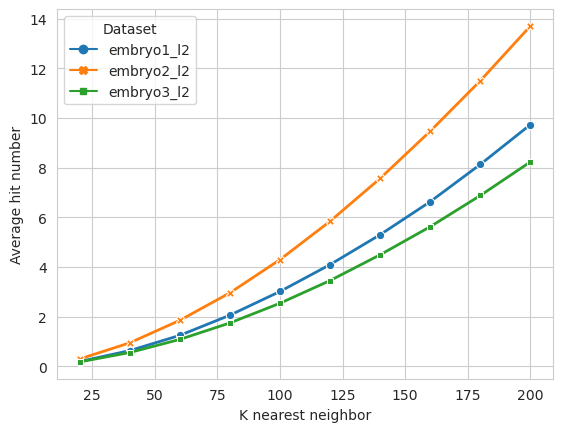

In [28]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 2.3.2 Average JSD and  spearman's rank correlation coefficient

In [29]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,embryo1_l2,0.599284,0.053024
1,embryo2_l2,0.530751,0.096083
2,embryo3_l2,0.610992,0.052866


## 3. Spatial location inference across platforms: human breast cancer datasets

### 3.1 Load data

In [30]:
DATA_ROOT = "../benchmarking_data"
human_breast_s06 = sc.read_h5ad(os.path.join(DATA_ROOT,"s06_normal.h5ad"))
human_breast_s08 = sc.read_h5ad(os.path.join(DATA_ROOT,"s08_normal.h5ad"))
print("human_breast_s06",human_breast_s06.shape,"human_breast_s08",human_breast_s08.shape)


human_breast_s06 (3037, 36503) human_breast_s08 (2801, 36503)


### 3.2 Spatial Reconstruction and evaluation


In [31]:
test_adata_list = {"embryo1_l2":embryo1_l2,"embryo2_l2":embryo2_l2,"embryo3_l2":embryo3_l2}
# set reference data
ref_adata = human_breast_s06

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

cur_test_adata = human_breast_s08
test_name = "10X visium S08"
cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
logging.info("Aligning data for "+test_name)
query_adata = cur_test_adata
predict_probs,predefined_locations = reconstruct(ref_adata,query_adata)
predicted_coor = getLocations(predefined_locations, predict_probs)
logging.info("Aligning DONE")
    
predicted_distances =  cdist(predicted_coor, predicted_coor)
predicted_sorted_ind = np.argsort(predicted_distances)
    
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)
    
# neighbor hit
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend([test_name]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
# JSD
cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
# Spearman rank correlation
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
JSD_spearman_res['Dataset'].append(test_name)
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for 10X visium S08


test data sparse to dense
cell_expression.shape (2801, 2519) atlas_expression.shape (2801, 2519) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 10.24 seconds )
Reconstructing spatial information with 2519 markers: 2801 cells and 2801 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2801/2801 [00:03<00:00, 730.30it/s]


In [32]:
res_summary_all.to_csv("results/novosparc_human_breast.csv")

### 3.3 Benchmarking results

#### 3.3.1 Neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

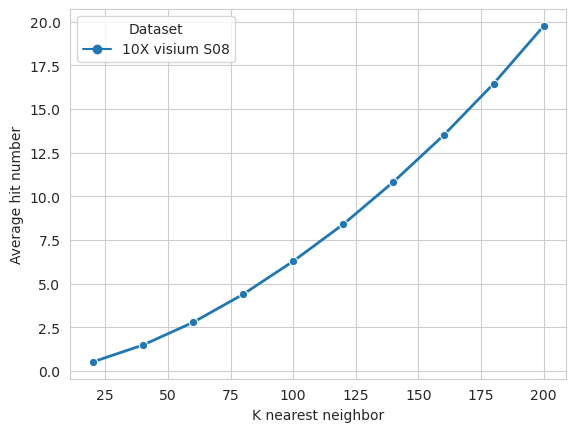

In [34]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 3.3.2 Average JSD and  spearman's rank correlation coefficient

In [35]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,10X visium S08,0.394582,0.043925


## 4. Spatial location inference: mouse brain cells generated by MERSCOPE

### 4.1. Load data

In [12]:
DATA_ROOT = "../benchmarking_data"
left_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_left_original.h5ad"))
right_brain_adata = sc.read_h5ad(os.path.join(DATA_ROOT,"s1r1_right_original.h5ad"))

### 4.2. Spatial Reconstruction and evaluation


In [14]:
# set reference data
ref_adata = left_brain_adata

neighbor_hit_res = {'Dataset':[],'K nearest neighbor':[],'Average hit number':[]}
JSD_spearman_res = {'Dataset':[],'Average JSD':[],"Average spearman's rank correlation coefficient":[]}
res_summary_all   = {"Dataset":[],"Cell type":[],"Average JSD":[],"Average spearman":[]}

cur_test_adata = right_brain_adata
test_name = "merfish"
cur_truth_coor = np.column_stack((cur_test_adata.obs['x'].values,cur_test_adata.obs['y'].values))
    
logging.info("Aligning data for "+test_name)
query_adata = cur_test_adata
predict_probs,predefined_locations = reconstruct(ref_adata,query_adata)
predicted_coor = getLocations(predefined_locations, predict_probs)
logging.info("Aligning DONE")
    
predicted_distances =  cdist(predicted_coor, predicted_coor)
predicted_sorted_ind = np.argsort(predicted_distances)
    
truth_distances =  cdist(cur_truth_coor, cur_truth_coor)
truth_sorted_ind = np.argsort(truth_distances)
    
# neighbor hit
cur_neighbor_res,cur_average_neighbor_res = utils.calNeiborHit(truth_sorted_ind,predicted_sorted_ind)
neighbor_hit_res['Dataset'].extend([test_name]*10)
neighbor_hit_res['K nearest neighbor'].extend(cur_average_neighbor_res['K nearest neighbor'])
neighbor_hit_res['Average hit number'].extend(cur_average_neighbor_res['Average hit number'])
    
# JSD
cur_truth_cell_types = cur_test_adata.obs['cell_type'].values
cur_jsd_list = utils.calJSD(truth_sorted_ind,predicted_sorted_ind,cur_truth_cell_types,neighbor_num=20)
    
# Spearman rank correlation
spearman_corr_list,spearman_p_list = utils.calSpearmanRank(predicted_distances,truth_distances)
    
JSD_spearman_res['Dataset'].append(test_name)
JSD_spearman_res['Average JSD'].append(np.mean(cur_jsd_list))
JSD_spearman_res["Average spearman's rank correlation coefficient"].append(np.mean(spearman_corr_list))
    
res_summary_all['Dataset'].extend([test_name]*len(cur_truth_cell_types))
res_summary_all['Cell type'].extend(cur_truth_cell_types)
res_summary_all['Average JSD'].extend(cur_jsd_list)
res_summary_all['Average spearman'].extend(spearman_corr_list)


neighbor_hit_res = pd.DataFrame(neighbor_hit_res)
JSD_spearman_res = pd.DataFrame(JSD_spearman_res)
res_summary_all = pd.DataFrame(res_summary_all)

INFO:root:Aligning data for merfish


cell_expression.shape (9419, 136) atlas_expression.shape (8923, 136) markers_metric.shape minkowski markers_metric_p.shape 2
type(cell_expression) <class 'numpy.ndarray'>
Setting up for reconstruction ... done ( 61.74 seconds )
Reconstructing spatial information with 136 markers: 9419 cells and 8923 locations ... 
Trying with epsilon: 5.00e-03


/home/smli/miniconda2/envs/pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:Aligning DONE
/autofs/bal12/smli/cell-to-location/src/github/benchmarking_related_methods/utils.py:55: RuntimeWarning: invalid value encountered in divide
  prediction_datasets = prediction_datasets/prediction_datasets.sum()
/autofs/bal12/smli/cell-to-location/src/github/benchmarking_related_methods/utils.py:56: RuntimeWarning: invalid value encountered in divide
  truth_datasets = truth_datasets/truth_datasets.sum()
100%|█████████████████████████████████████████████████████████████████████| 9419/9419 [00:30<00:00, 311.52it/s]


### 4.3 Benchmarking results

#### 4.3.1 Neighbor hit

<AxesSubplot: xlabel='K nearest neighbor', ylabel='Average hit number'>

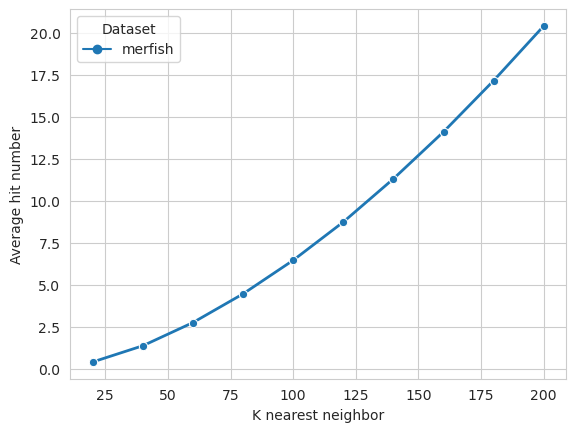

In [16]:
sns.set_style('whitegrid')
sns.lineplot(data=neighbor_hit_res,x="K nearest neighbor",y="Average hit number",hue="Dataset",markers=True,style='Dataset',\
             dashes=False,linewidth=2)

#### 4.3.2 Average JSD and  spearman's rank correlation coefficient

In [17]:
display(JSD_spearman_res)

,Dataset,Average JSD,Average spearman's rank correlation coefficient
0,merfish,NaN,0.341844
